In [3]:
# Importation de toutes nos librairies
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, LearningCurveDisplay, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, chi2

from sklearn.metrics import (confusion_matrix, roc_auc_score, balanced_accuracy_score, make_scorer, recall_score,
                            precision_score, precision_recall_curve, auc, classification_report, f1_score)

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

from sklearn.compose import make_column_transformer, make_column_selector

from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.pipeline import make_pipeline, Pipeline

from scipy.stats import randint, uniform, loguniform
from sklearn.inspection import permutation_importance
import shap
from sklearn.inspection import permutation_importance
shap.initjs()

In [5]:
fusion_df = pd.read_csv('../fichiers/donnéesDeFusion.csv')
fusion_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 23 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   a_quitte_l_entreprise                      1470 non-null   object
 1   nombre_participation_pee                   1470 non-null   int64 
 2   nb_formations_suivies                      1470 non-null   int64 
 3   distance_domicile_travail                  1470 non-null   int64 
 4   niveau_education                           1470 non-null   int64 
 5   domaine_etude                              1470 non-null   object
 6   frequence_deplacement                      1470 non-null   object
 7   annees_depuis_la_derniere_promotion        1470 non-null   int64 
 8   satisfaction_employee_environnement        1470 non-null   int64 
 9   note_evaluation_precedente                 1470 non-null   int64 
 10  niveau_hierarchique_poste           

## PREPROCESSING

In [27]:
# fonction de separation
def data_separator(df, target):
    # on retire target
    X = df.drop(columns=[target])
    y = df[target]
    return X, y


# fonction d'encodage
def label_encode_columns(df):
    df_encoded = df.copy()
    for col in df_encoded.columns:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    return df_encoded


# fonction d'evaluation
def evaluation(model, X_test, y_test, scorer='recall', cv=4, seuil = 0.50):
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred  = (y_proba >= seuil).astype(int)
    
    # Métriques principales
    metrics = {
        "balanced_accuracy" : balanced_accuracy_score(y_test, y_pred),
        "roc_auc"           : roc_auc_score(y_test, y_proba)
    }

    # PR-AUC
    pr_precision, pr_recall, thr = precision_recall_curve(y_test, y_proba)
    metrics["pr_auc"] = auc(pr_recall, pr_precision)
    
    # Les métriques
    print("\n=== Métriques ===")
    for k, v in metrics.items():
        print(f"{k:17s}: {v:.4f}")
        
    print("\n=== Classification report ===")
    print(classification_report(y_test, y_pred, digits=3))
    
    # Matrice de confusion heatmap
    cm = confusion_matrix(y_test, y_pred)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[0])
    axes[0].set_title("Matrice de confusion")
    axes[0].set_xlabel("Prédit")
    axes[0].set_ylabel("Réel")

    # Courbe PR
    axes[1].plot(pr_recall, pr_precision, color='darkorange')
    axes[1].set_title(f"Precision-Recall (AUC = {metrics['pr_auc']:.3f})")
    axes[1].set_xlabel("Recall")
    axes[1].set_ylabel("Precision")
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    
    # Learning curve
    LearningCurveDisplay.from_estimator(model, X_train, y_train, scoring=scorer, ax=axes[2], cv=cv, n_jobs=-1)
    axes[2].set_title(f"Learning Curve ({scorer})")
    
    plt.tight_layout()
    plt.show()
    print("="*150)


# recherche de meilleur seuil pour la sortie du model 
def search_best_threshold(model, X_test, y_test):
    best_f1 = 0
    best_seuil = 0
    # Prédictions probabilistes
    y_proba = model.predict_proba(X_test)[:, 1]

    # Recherche du meilleur seuil
    for seuil in [i / 100 for i in range(10, 70)]:
        y_pred_temp = (y_proba >= seuil).astype(int)
        f1 = f1_score(y_test, y_pred_temp)
        if f1 > best_f1:
            best_f1 = f1
            best_seuil = seuil
    return best_seuil, best_f1


# Calcul d'un score global (ça nous permettra juste de faire le choix du model final)
def composite_score(metrics_dict, weights):
    """Calcule le score composite d'un modèle à partir des métriques et des poids."""
    return sum(metrics_dict[m] * weights[m] for m in weights)

In [10]:
# Preprocessing
# Sélection des numériques et catégorielle
num_selector = make_column_selector(dtype_include=[np.number])
cate_selector = make_column_selector(dtype_exclude=[np.number])

    
num_pipeline = make_pipeline(
    MinMaxScaler()
)

# Pipeline catégoriel - LabelEncoder
label_pipeline = make_pipeline(
    FunctionTransformer(label_encode_columns, validate=False)
)

# preprocesseur
preprocessor = make_column_transformer(
    (num_pipeline, num_selector),
    (label_pipeline, cate_selector),
    verbose_feature_names_out=False,
    n_jobs=-1
)

In [12]:
final_df = fusion_df.drop(columns=['a_quitte_l_entreprise', 'poste', 'domaine_etude']) # car nous avons déjà sa forme numérique
final_df.shape

(1470, 20)

In [14]:
X, y = data_separator(final_df, 'target')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0, stratify=final_df['target'])
print('X_train :', X_train.shape)
print('X_test :', X_test.shape)

X_train : (1176, 19)
X_test : (294, 19)


## MODELISATION

* Prédire les départs d’employés en minimisant les faux négatifs (FN) → donc le recall sur la classe 1 est primordial.
______
* Comme notre projet est de prédire quels employés risquent de quitter l’entreprise. Il est donc plus risqué de manquer un vrai départ (FN) que de faire une fausse alerte (FP). On privilégie donc des métriques qui captent bien les cas de départ, même si le dataset est déséquilibré.
    - Recall (rappel) : C’est la métrique clé ici -> elle nous dit si notre modèle réussit à repérer les vrais démissionnaires.
    - F1-score : Synthèse entre recall et précision.
    - Precision (précision) : Pour s’assurer que les employés détectés comme “à risque” le sont vraiment.
    - AUC-ROC : Pour évaluer la capacité globale du modèle à distinguer les deux classes (départ vs reste). (>0.8) est généralement bon.
    - Matrice de confusion : Elle t’aide à analyser les erreurs (faux positifs / faux négatifs).
    - Balanced Accuracy : Si les classes sont très déséquilibrées, elle donne un score plus juste en moyenne.
    - Courbe Precision-Recall : Pour optimiser le seuil de décision (proba à partir de laquelle un employé est considéré à risque).

In [18]:
# Pondérations selon nos priorités ( ici ça nous permettra juste de faire le choix du model final)
metrics_weights = {
    'Recall': 0.40,
    'F1-score': 0.25,
    'Precision': 0.15,
    'AUC-ROC': 0.10,
    'Balanced Accuracy': 0.10
}

******** dummy ********
Meilleur seuil : 0.1 avec F1-score = 0.2756598240469208

=== Métriques ===
balanced_accuracy: 0.5000
roc_auc          : 0.5000
pr_auc           : 0.5799

=== Classification report ===
              precision    recall  f1-score   support

           0      0.000     0.000     0.000       247
           1      0.160     1.000     0.276        47

    accuracy                          0.160       294
   macro avg      0.080     0.500     0.138       294
weighted avg      0.026     0.160     0.044       294



C:\Users\laelo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\laelo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\laelo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


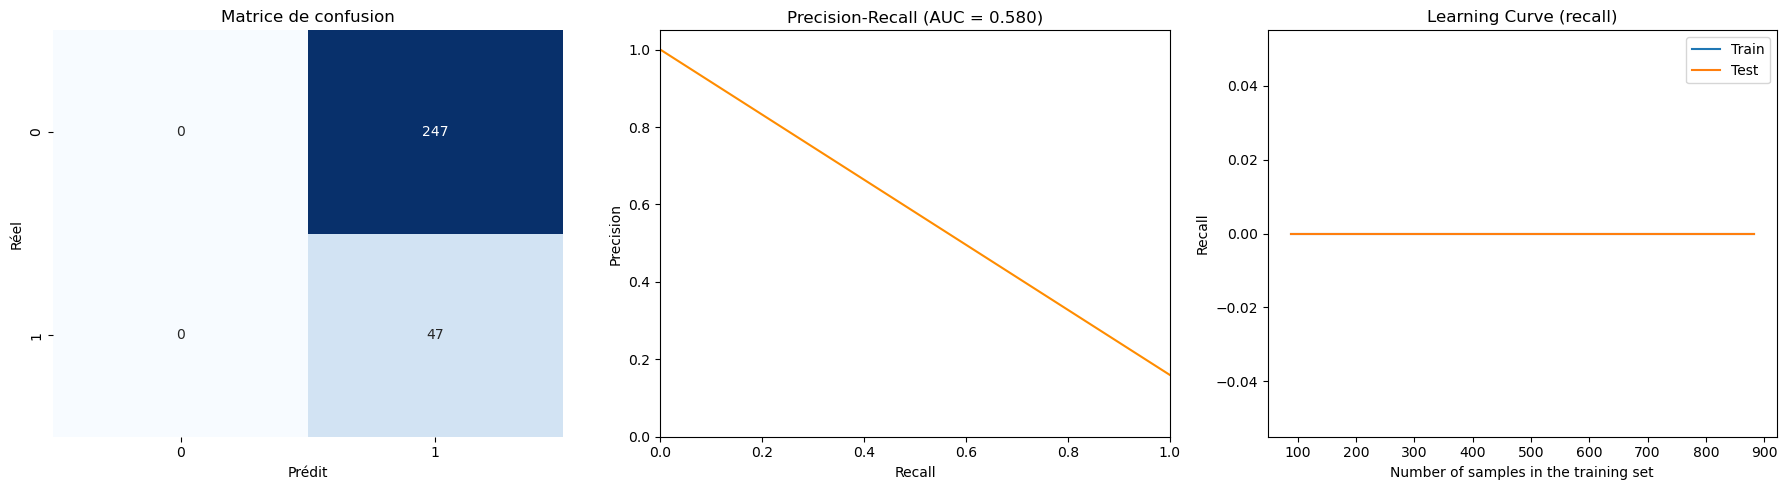

******** linear ********
Meilleur seuil : 0.69 avec F1-score = 0.4827586206896552

=== Métriques ===
balanced_accuracy: 0.6849
roc_auc          : 0.7935
pr_auc           : 0.5488

=== Classification report ===
              precision    recall  f1-score   support

           0      0.898     0.923     0.910       247
           1      0.525     0.447     0.483        47

    accuracy                          0.847       294
   macro avg      0.711     0.685     0.696       294
weighted avg      0.838     0.847     0.842       294



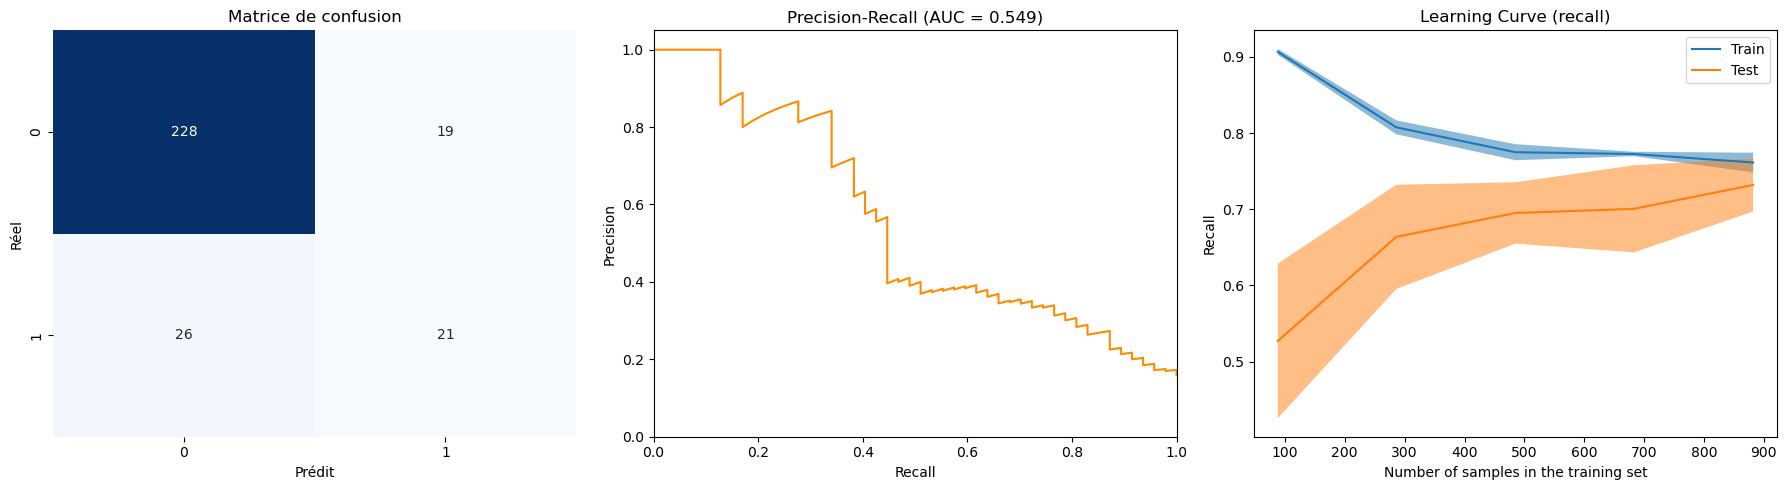

******** g_boost ********
Meilleur seuil : 0.2 avec F1-score = 0.5454545454545454

=== Métriques ===
balanced_accuracy: 0.7838
roc_auc          : 0.8095
pr_auc           : 0.5467

=== Classification report ===
              precision    recall  f1-score   support

           0      0.947     0.802     0.868       247
           1      0.424     0.766     0.545        47

    accuracy                          0.796       294
   macro avg      0.685     0.784     0.707       294
weighted avg      0.864     0.796     0.817       294



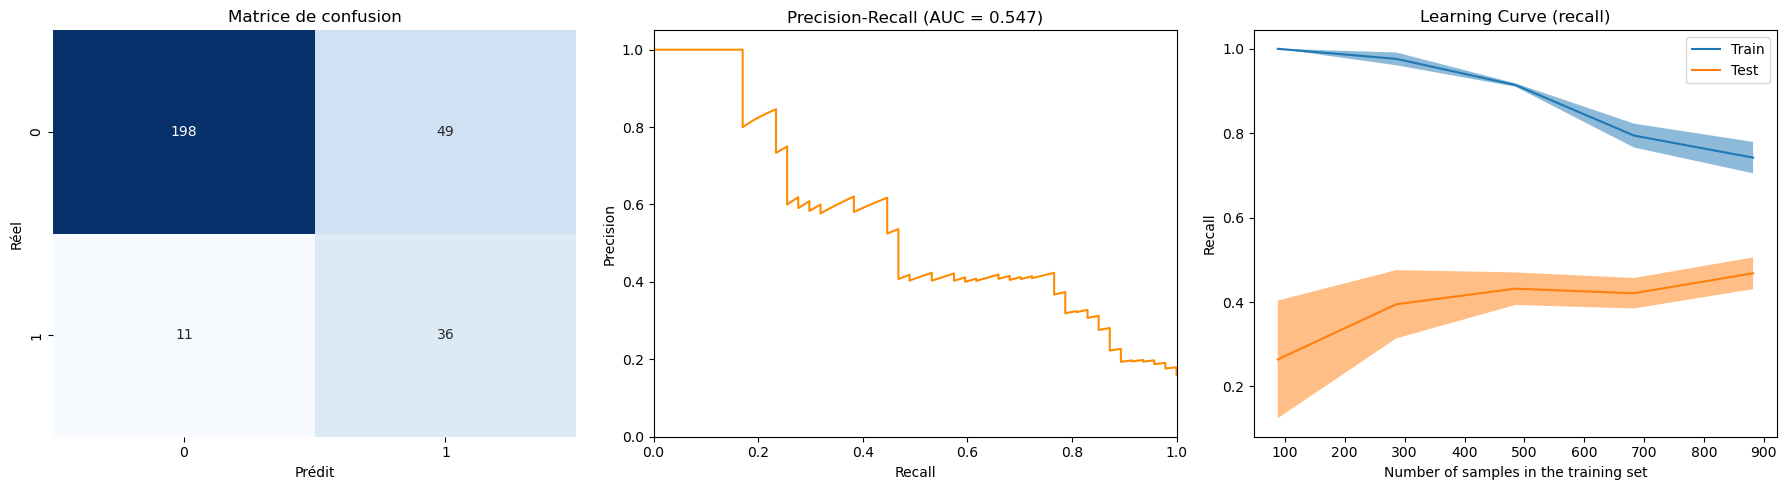

******** IMBforest ********
Meilleur seuil : 0.29 avec F1-score = 0.5714285714285714

=== Métriques ===
balanced_accuracy: 0.7625
roc_auc          : 0.8083
pr_auc           : 0.5602

=== Classification report ===
              precision    recall  f1-score   support

           0      0.928     0.887     0.907       247
           1      0.517     0.638     0.571        47

    accuracy                          0.847       294
   macro avg      0.723     0.762     0.739       294
weighted avg      0.862     0.847     0.853       294



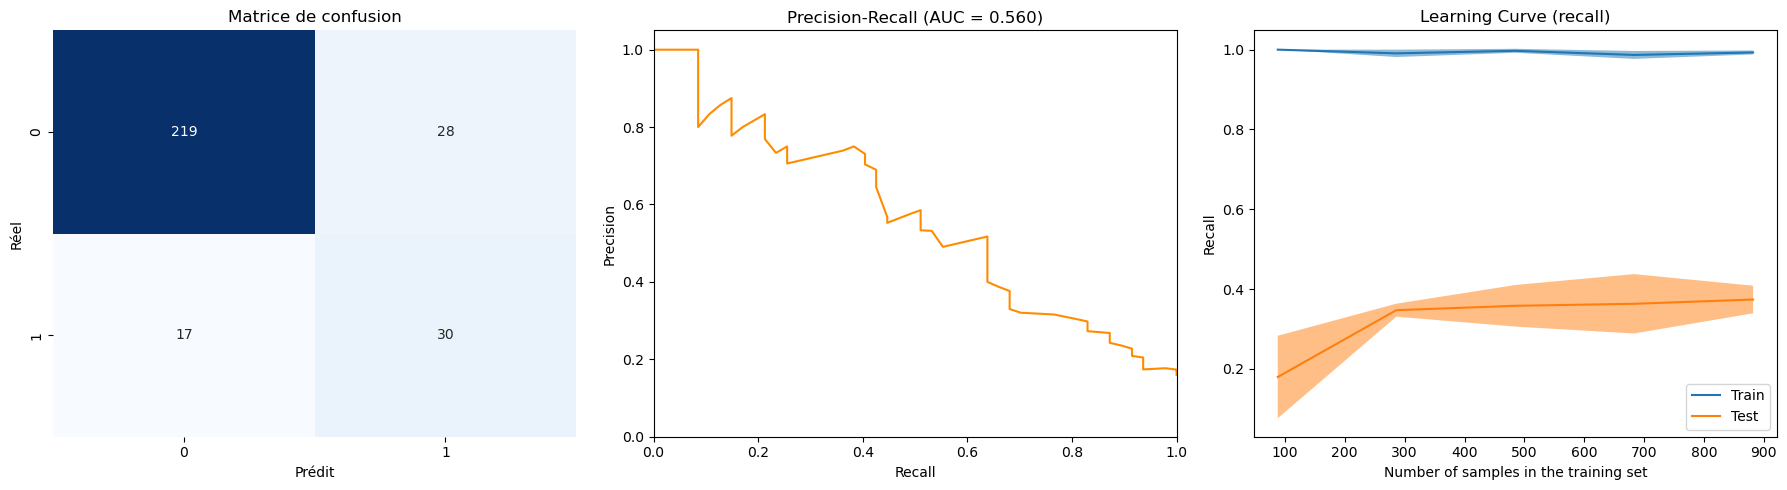

In [20]:
models = {
    'dummy': DummyClassifier(),
    'linear': LogisticRegression(random_state=0),
    'g_boost': GradientBoostingClassifier(random_state=0),
    'IMBforest' : BalancedRandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=0)
}

for name, base_model in models.items():
    # Pipeline complet : prétraitement, oversampling, modèle
    model = make_pipeline( 
            preprocessor,
            SelectKBest(score_func= f_classif, k=19),
            SMOTETomek(random_state=0), # avec un oversampling
            base_model
    )
    model.fit(X_train, y_train)
    best_seuil, best_f1 = search_best_threshold(model, X_test, y_test)
    # Évaluation avec le meilleur seuil trouvé
    print('********', name, '********')
    print(f"Meilleur seuil : {best_seuil} avec F1-score = {best_f1}")
    evaluation(model, X_test, y_test, seuil=best_seuil)

In [21]:
# Choix du model final en fonction de la pondération de nos différents metrics
models_results = {
    'g_boost': {
        'Recall': 0.766,
        'F1-score': 0.545,
        'Precision': 0.424,
        'AUC-ROC': 0.8095,
        'Balanced Accuracy': 0.7838
    },
    'IMBforest': {
        'Recall': 0.638,
        'F1-score': 0.571,
        'Precision': 0.517,
        'AUC-ROC': 0.8083,
        'Balanced Accuracy': 0.7625
    },
    'linear': {
        'Recall': 0.447,
        'F1-score': 0.483,
        'Precision': 0.525,
        'AUC-ROC': 0.7935,
        'Balanced Accuracy': 0.6849
    }
}

# Calcul & tri des modèles
scores = {model: composite_score(metrics, metrics_weights) for model, metrics in models_results.items()}
scores_df = pd.DataFrame.from_dict(scores, orient='index', columns=['Composite Score'])
scores_df = scores_df.sort_values(by='Composite Score', ascending=False)

print(scores_df)

           Composite Score
g_boost            0.66558
IMBforest          0.63258
linear             0.52614


* Comme notre objectif principal est de maximiser le rappel (Recall) sur la classe 1 -> g_boost est à privilégier.

## OPTIMISATION DE NOTRE MODEL

In [80]:
best_model = make_pipeline(
    preprocessor,  
    SelectKBest(),
    SMOTETomek(random_state=0),
    GradientBoostingClassifier(random_state=0)
)


metrics = {
    'Recall': make_scorer(recall_score, average='binary'),  
    'F1-score': make_scorer(f1_score, average='binary'),
    'Precision': make_scorer(precision_score, average='binary'),
    'Balanced Accuracy': make_scorer(balanced_accuracy_score)
}

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'gradientboostingclassifier__learning_rate': 0.014915219870164514, 'gradientboostingclassifier__max_depth': 2, 'gradientboostingclassifier__min_samples_leaf': 1, 'gradientboostingclassifier__min_samples_split': 4, 'gradientboostingclassifier__n_estimators': 179, 'gradientboostingclassifier__subsample': 0.7654672916585682, 'selectkbest__k': 10, 'selectkbest__score_func': <function chi2 at 0x000002B8C6C1C040>, 'smotetomek__sampling_strategy': 0.770494883184115}
Meilleur seuil : 0.43 avec F1-score = 0.48

=== Métriques ===
balanced_accuracy: 0.6966
roc_auc          : 0.8025
pr_auc           : 0.5171

=== Classification report ===
              precision    recall  f1-score   support

           0      0.905     0.883     0.893       247
           1      0.453     0.511     0.480        47

    accuracy                          0.823       294
   macro avg      0.679     0.697     0.687       294
weighted avg      0.832     0

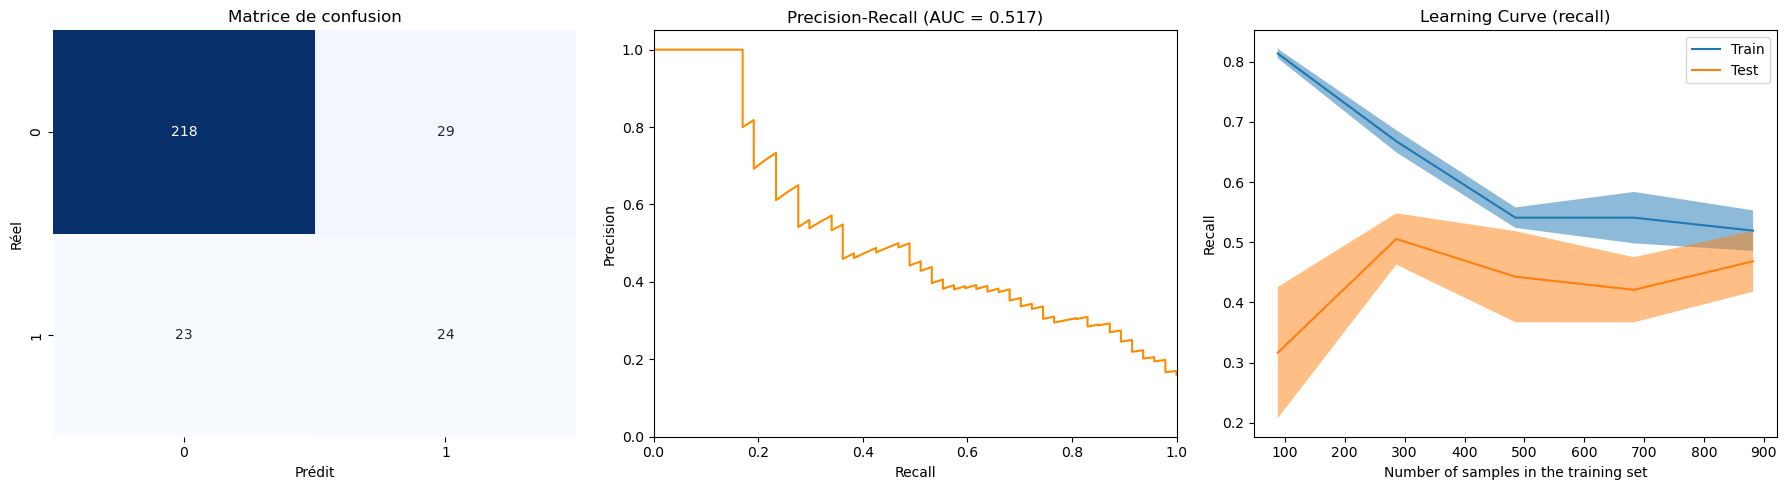

In [82]:
param_dist = {
    'gradientboostingclassifier__learning_rate': uniform(0.005, 0.3),          # ~0.005 à 0.305
    'gradientboostingclassifier__max_depth': randint(2, 15),                   # 2 à 14 inclus
    'gradientboostingclassifier__min_samples_leaf': randint(1, 10),            # 1 à 9 inclus
    'gradientboostingclassifier__min_samples_split': randint(2, 15),           # 2 à 14 inclus
    'gradientboostingclassifier__n_estimators': randint(50, 600),              # 50 à 599 inclus
    'gradientboostingclassifier__subsample': uniform(0.5, 0.5),                 # 0.5 à 1.0
    'selectkbest__k': randint(5, 30),                                           # 5 à 29 inclus
    'selectkbest__score_func': [mutual_info_classif, f_classif, chi2],
    'smotetomek__sampling_strategy': uniform(0.3, 0.7)                          # 0.3 à 1.0
}


grid_RSCV = RandomizedSearchCV(
    best_model, param_dist, n_iter=100, cv=5, scoring=metrics, refit='Recall',
    n_jobs=-1, verbose=2, random_state=42, error_score='raise'
)

grid_RSCV.fit(X_train, y_train)

print(grid_RSCV.best_params_)
best_seuil, best_f1 = search_best_threshold(grid_RSCV.best_estimator_, X_test, y_test)
# Évaluation avec le meilleur seuil trouvé
print('='*100)
print(f"Meilleur seuil : {best_seuil} avec F1-score = {best_f1}")
evaluation(grid_RSCV.best_estimator_, X_test, y_test, seuil=best_seuil)

Fitting 4 folds for each of 128 candidates, totalling 512 fits
{'gradientboostingclassifier__learning_rate': 0.015, 'gradientboostingclassifier__max_depth': 2, 'gradientboostingclassifier__min_samples_leaf': 1, 'gradientboostingclassifier__min_samples_split': 2, 'gradientboostingclassifier__n_estimators': 100, 'gradientboostingclassifier__subsample': 0.76, 'selectkbest__k': 10, 'selectkbest__score_func': <function chi2 at 0x000002B8C6C1C040>, 'smotetomek__sampling_strategy': 'auto'}
Meilleur seuil : 0.47 avec F1-score = 0.4918032786885246

=== Métriques ===
balanced_accuracy: 0.7281
roc_auc          : 0.7962
pr_auc           : 0.4944

=== Classification report ===
              precision    recall  f1-score   support

           0      0.922     0.818     0.867       247
           1      0.400     0.638     0.492        47

    accuracy                          0.789       294
   macro avg      0.661     0.728     0.679       294
weighted avg      0.839     0.789     0.807       294



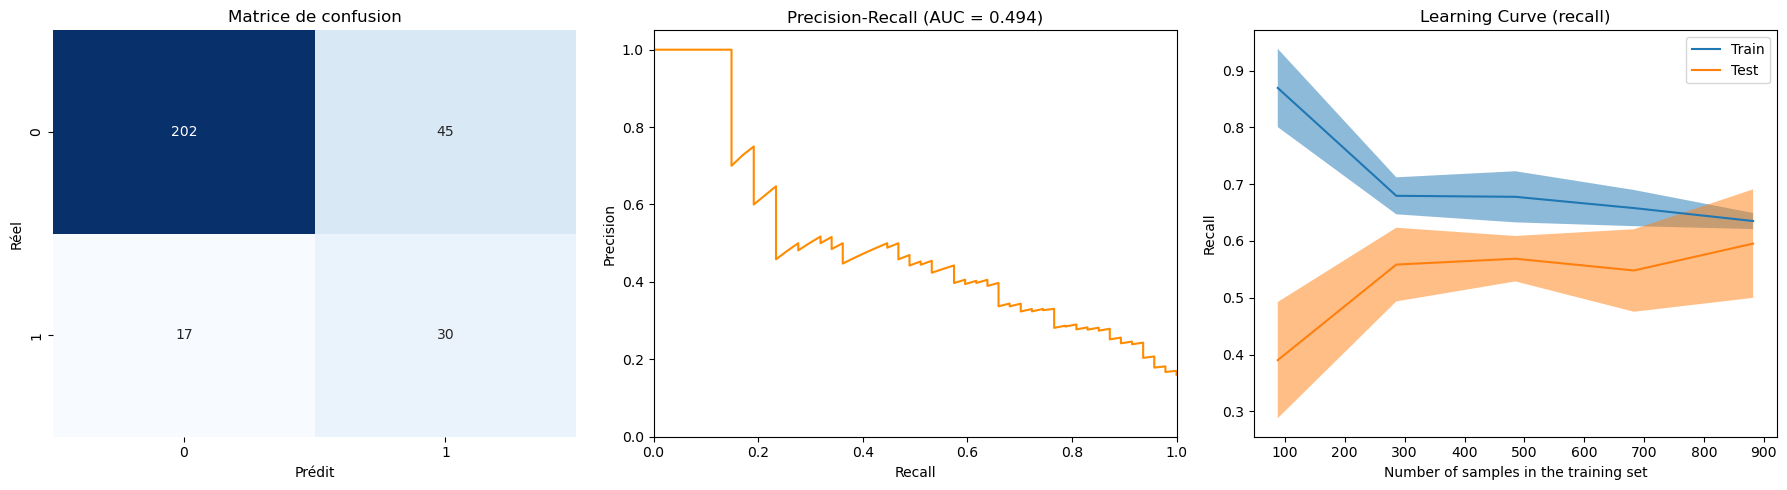

In [88]:
# Grille optimisée et réduite
param_grid = {
    'gradientboostingclassifier__learning_rate': [0.1, 0.015],
    'gradientboostingclassifier__max_depth': [2, 3],
    'gradientboostingclassifier__min_samples_leaf': [1],
    'gradientboostingclassifier__min_samples_split': [2, 4],
    'gradientboostingclassifier__n_estimators': [100, 179],
    'gradientboostingclassifier__subsample': [1.0, 0.76],
    'selectkbest__k': [10, 'all'],
    'selectkbest__score_func': [chi2],  # uniquement le best trouvé
    'smotetomek__sampling_strategy': [0.77, 'auto']
}

grid_gb = GridSearchCV(
    best_model, param_grid, cv=4, scoring=metrics, refit = 'Recall',
    n_jobs=-1, verbose=2, error_score='raise'
)

grid_gb.fit(X_train, y_train)

print(grid_gb.best_params_)
best_seuil, best_f1 = search_best_threshold(grid_gb.best_estimator_, X_test, y_test)
# Évaluation avec le meilleur seuil trouvé
print('='*100)
print(f"Meilleur seuil : {best_seuil} avec F1-score = {best_f1}")
evaluation(grid_gb.best_estimator_, X_test, y_test, seuil=best_seuil)

## INTERPRETATION DE NOTRE MODEL FINAL AVEC SHAP


=== Métriques ===
balanced_accuracy: 0.7838
roc_auc          : 0.8095
pr_auc           : 0.5467

=== Classification report ===
              precision    recall  f1-score   support

           0      0.947     0.802     0.868       247
           1      0.424     0.766     0.545        47

    accuracy                          0.796       294
   macro avg      0.685     0.784     0.707       294
weighted avg      0.864     0.796     0.817       294



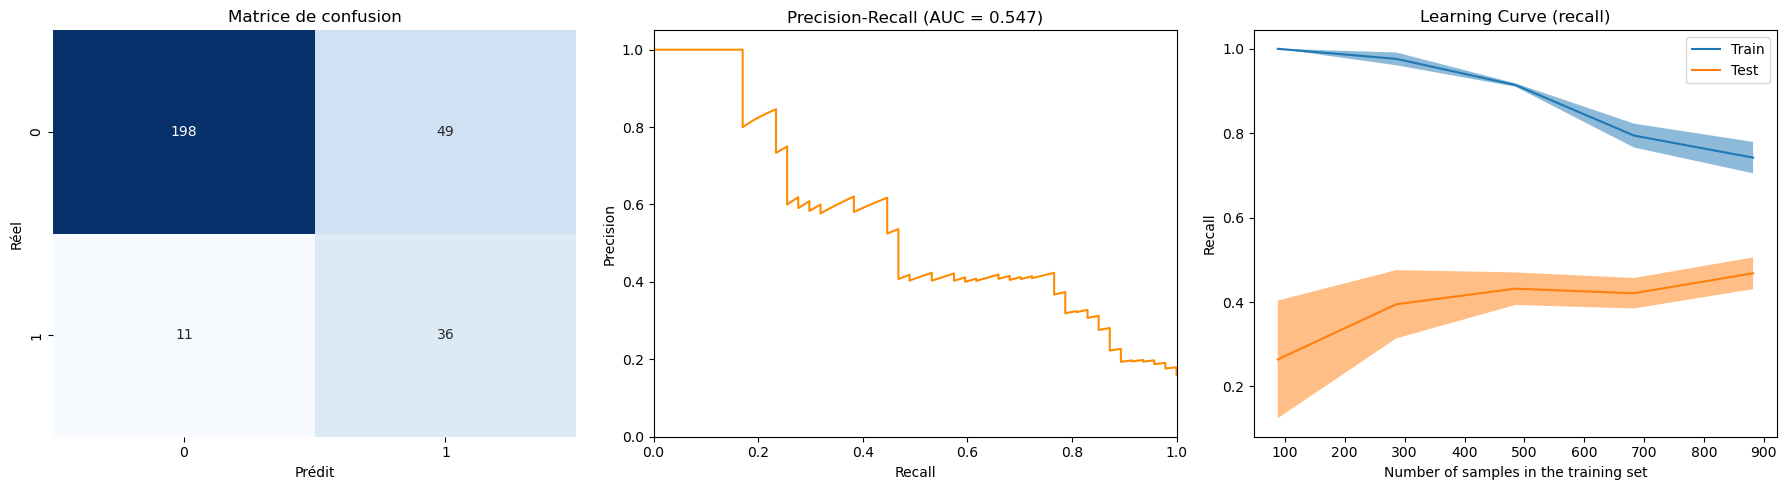

In [29]:
final_model = make_pipeline( 
            preprocessor,
            SMOTETomek(random_state=0), # avec un oversampling
            GradientBoostingClassifier(random_state=0)
    )
final_model.fit(X_train, y_train)
evaluation(final_model, X_test, y_test, seuil=0.2)

* Performance du modèle final (Gradient Boosting + SMOTETomek )

* Rapport de classification
| Classe | Précision | Rappel | F1-score | Support |
|--------|-----------|--------|----------|---------|
| 0 (Reste)        | 0.947 | 0.802 | 0.868 | 247 |
| 1 (Démissionne)  | 0.424 | 0.766 | 0.545 | 47  |

---

* Interprétation
- Le modèle **détecte 76 % des démissionnaires** (classe 1), ce qui est crucial pour les RH.  
- La précision sur les démissions est plus faible (42 %), mais les **fausses alertes** sont acceptables dans ce contexte.  
- Très bonne performance sur les employés restants (classe 0), avec 95 % de précision.  
- Globalement, le modèle offre un **bon compromis entre rappel et précision**, avec une capacité à généraliser confirmée par l’AUC ROC (0.81).  

* **VISUALISATION**
- Matrice de confusion : équilibre entre vrais positifs et faux positifs  
- Courbe Précision-Rappel (PR AUC = 0.55) : performance correcte malgré le déséquilibre des classes  
- Courbe d’apprentissage : écart train/test -> suggère qu’**ajouter plus de données** pourrait encore améliorer la détection

---

* Courbe d'Apprentissage (Recall)

- **Sur-apprentissage (overfitting)** visible mais diminue beaucoups au fur et a mesure qu'on augmente des données :
  - Train Recall ≈ 0.78+
  - Test Recall ≈ 0.30 – 0.77
- L’écart **diminue avec plus de données** -> possibilité d’amélioration en collectant plus d’échantillons.

---

In [31]:
print(final_model.named_steps)

{'columntransformer': ColumnTransformer(n_jobs=-1,
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('minmaxscaler',
                                                  MinMaxScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001455B353200>),
                                ('pipeline-2',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(func=<function label_encode_columns at 0x000001455F6C1F80>))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001455B351490>)],
                  verbose_feature_names_out=False), 'smotetomek': SMOTETomek(random_state=0), 'gradientboostingclassifier': GradientBoostingClassifier(random_state=0)}


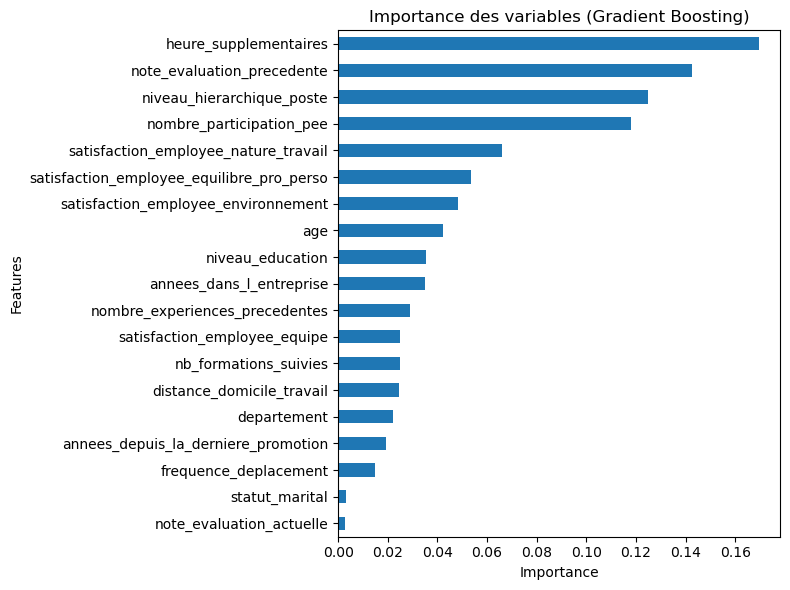

In [33]:
# Étape 1 : Extraire le préprocesseur et le classifieur
preprocessor = final_model.named_steps['columntransformer']
clf = final_model.named_steps['gradientboostingclassifier']

# Étape 2 : Récupérons les features transformées avec get_feature_names_out ou manuellement
try:
    feature_names = preprocessor.get_feature_names_out()
except:
    # nous allons le faire manuellement si certaines étapes custom bloquent get_feature_names_out
    num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()
    feature_names = num_cols + cat_cols

# Étape 3 : Importances natives du Gradient Boosting
importances_native = pd.Series(clf.feature_importances_, index=feature_names)
importances_native = importances_native.sort_values(ascending=True)

plt.figure(figsize=(8, 6))
importances_native.plot(kind='barh', title='Importance des variables (Gradient Boosting)')
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

* Variables les plus influentes (Features Importance Native)
- **heure_supplementaires (0.16)** : Indicateur clé, fortement lié à la cible.
- **note_evaluation_precedente (0.14)** : Les performances passées pèsent lourd.
- **niveau_hierarchique_poste (0.12)** : Le niveau dans l’organisation joue un rôle important.
* Influence moyenne
- **nombre_participation_pee (0.10)** : Signe d'engagement potentiel.
- **satisfaction_employee_nature_travail (0.08)** : Impact notable sur la cible.
- **satisfaction_employee_equilibre_pro_perso (0.06)** et **satisfaction_employee_environnement (0.06)** : Effets modérés mais réels.
* Influence faible
- **age, niveau_education, annees_dans_l_entreprise** (~0.04–0.05) : Impact limité.
- **note_evaluation_actuelle (0.00)** : Aucun effet détecté par le modèle.

---

* **En bref** : Les variables **comportementales et historiques de performance** influencent bien plus le modèle que les données purement démographiques.

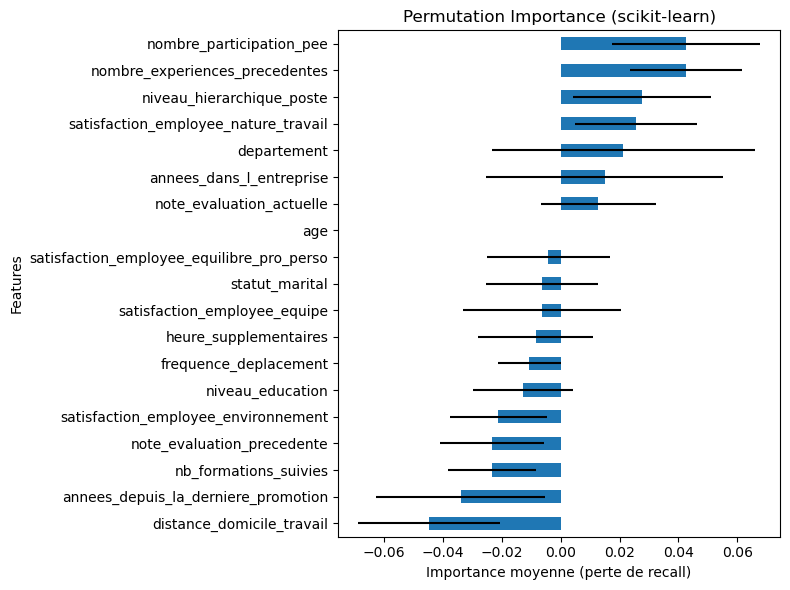

In [35]:
# Calculons la permutation importance
result = permutation_importance(
    final_model,
    X_test,
    y_test,
    scoring='recall',
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

importances_mean = result.importances_mean
importances_std = result.importances_std

# Séries pandas
importances_perm = pd.Series(importances_mean, index=feature_names)
importances_perm_std = pd.Series(importances_std, index=feature_names)

# Trions pour affichage
sorted_idx = importances_perm.sort_values(ascending=True).index
importances_perm = importances_perm.loc[sorted_idx]
importances_perm_std = importances_perm_std.loc[sorted_idx]

# Étape 6 : Affichage permutation importance

plt.figure(figsize=(8,6))
ax = importances_perm.plot(kind='barh', xerr=importances_perm_std, title='Permutation Importance (scikit-learn)')
plt.xlabel("Importance moyenne (perte de recall)")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

* Variables les plus influentes (Permutation Importance)
- **nombre_participation_pee** : Impact très fort sur la baisse de recall quand perturbée.
- **nombre_experiences_precedentes** : Fort lien avec la cible.
- **niveau_hierarchique_poste** : Influence marquée sur la performance du modèle.
- **satisfaction_employee_nature_travail** : Indicateur important de la cible.
* Influence moyenne
- **departement**, **annees_dans_l_entreprise**, **note_evaluation_actuelle**, **age** : Impact notable mais moins critique.
- **satisfaction_employee_equilibre_pro_perso**, **statut_marital**, **satisfaction_employee_equipe** : Effet intermédiaire.
* Influence faible
- **heure_supplementaires**, **frequence_deplacement**, **niveau_education** : Rôle limité selon la permutation importance.
- **satisfaction_employee_environnement**, **note_evaluation_precedente**, **nb_formations_suivies**,  
  **annees_depuis_la_derniere_promotion**, **distance_domicile_travail** : Impact marginal.

---

* Comparaison avec l’Importance native du Gradient Boosting

| Rang élevé en **Native FI**               | Rang élevé en **Permutation FI**         | Observations |
|--------------------------------------------|-------------------------------------------|--------------|
| heure_supplementaires (#1 en natif)        | Passe en **faible** en permutation        | Suggère que son impact natif vient de corrélations avec d'autres variables. |
| note_evaluation_precedente (#2 natif)      | Faible en permutation                     | Influence directe limitée quand les autres variables sont fixées. |
| niveau_hierarchique_poste (élevé natif)    | Également élevé en permutation            | Influence robuste, confirmée par les deux approches. |
| nombre_participation_pee (moyen natif)     | Devient la plus importante en permutation | Montre son impact direct sur le rappel du modèle. |
| satisfaction_employee_nature_travail       | Importante dans les deux                  | Variable stable et prédictive dans les deux mesures. |

---

* **En bref** :  
- **Importance native** mesure l’impact basé sur la construction interne des arbres -> peut surévaluer des variables corrélées.  
- **Permutation importance** teste l’impact réel sur la métrique choisie (ici le recall) en perturbant chaque variable -> met en avant celles qui contribuent réellement à la performance finale.  
- Dans notre cas, certaines variables fortes en *native* chutent dans *permutation* (ex. : heures supplémentaires), signe d’effets de redondance. D’autres, moins visibles en natif, émergent comme cruciales (ex. : participation au PEE).

In [38]:
# Créons l'explainer shap
explainer = shap.TreeExplainer(clf)
# Calcul des valeurs shap sur X_test transformé
X_test_transformed = preprocessor.transform(X_test)  
shap_values = explainer(X_test_transformed)

In [40]:
shap_values.shape

(294, 19)

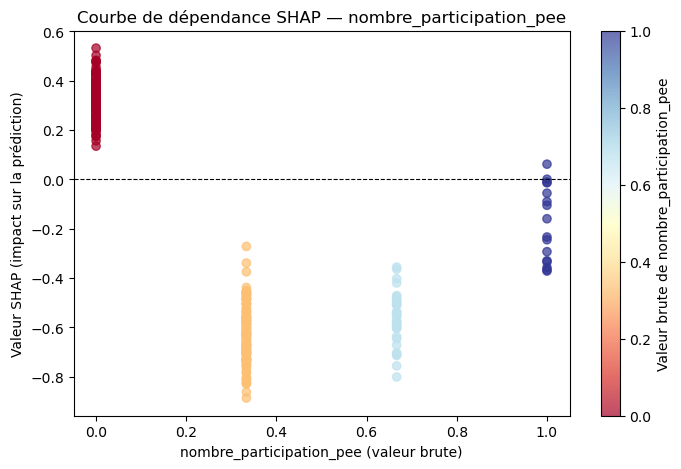

In [42]:
# DEPENDENCE PLOT SUR UNE FEATURE SPÉCIFIQUE
# Choisons une feature à illustrer
feat_name = "nombre_participation_pee"  # ici je choisi cette variable
feature_idx = list(feature_names).index(feat_name)

# Valeurs brutes de la feature et valeurs SHAP associées
feature_values = X_test_transformed[:, feature_idx]
shap_feature_values = shap_values.values[:, feature_idx]

plt.figure(figsize=(8,5))
sc = plt.scatter(
    feature_values,          # valeur brute
    shap_feature_values,     # valeur SHAP
    c=feature_values,        # couleur = valeur brute
    cmap="RdYlBu",
    alpha=0.7
)
plt.colorbar(sc, label=f"Valeur brute de {feat_name}")
plt.axhline(0, color="k", linestyle="--", linewidth=0.8)
plt.xlabel(f"{feat_name} (valeur brute)")
plt.ylabel("Valeur SHAP (impact sur la prédiction)")
plt.title(f"Courbe de dépendance SHAP — {feat_name}")
plt.show()

* Interprétation : Courbe de dépendance SHAP — `nombre_participation_pee`

**Lecture du graphique :**
- **Axe X** : Valeur brute de la variable (`0` = aucune participation, `1` = participation).  
- **Axe Y** : Valeur SHAP (impact sur la probabilité de démission).  
- **Couleurs** : indiquent aussi la valeur brute de la variable.  

**Analyse :**
- Lorsque la participation est **nulle (0)**, les valeurs SHAP sont majoritairement **positives** → cela contribue à **augmenter la probabilité de démission**.  
- Lorsque la participation est **élevée (1)**, les valeurs SHAP deviennent **négatives** → cela contribue à **réduire la probabilité de démission**.  
- L’effet global est donc **monotone décroissant** : plus la participation est forte, plus elle agit comme facteur de rétention.  
- La dispersion verticale montre que l’impact exact dépend aussi d’autres variables (interactions).  

**En résumé :**
Une faible participation au PEE est un signal de risque de départ,  
Tandis qu’une participation forte joue un rôle protecteur contre la démission.

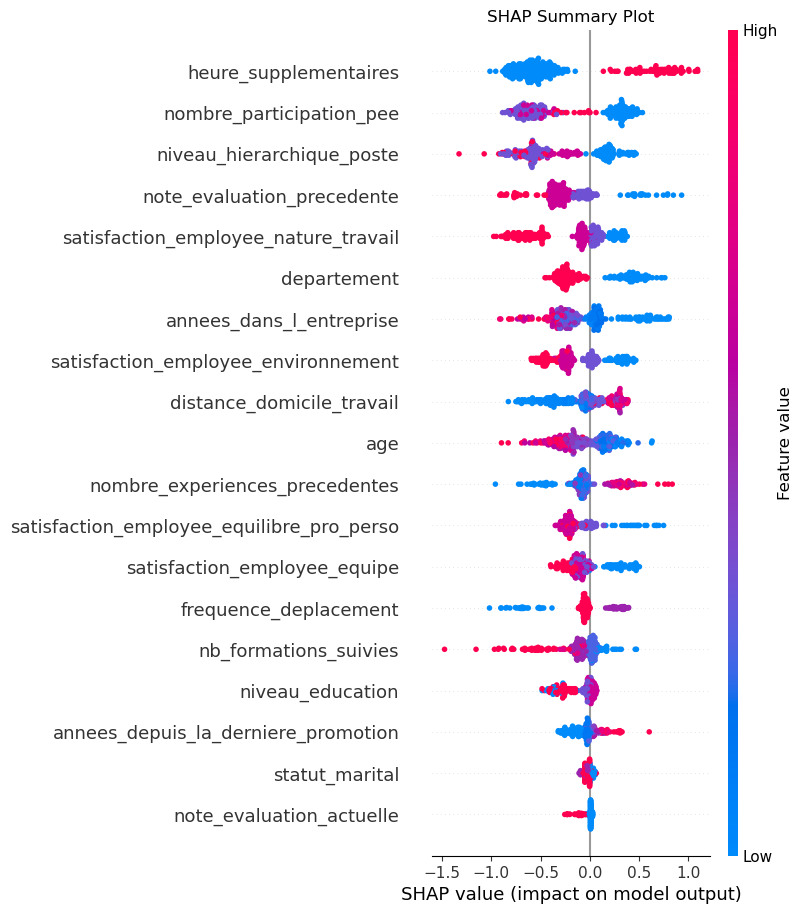

In [44]:
fig, ax = plt.subplots(figsize=(8, 6))
shap.summary_plot(
    shap_values,              # (n_samples, n_features)
    X_test_transformed,
    feature_names=feature_names,
    show=False
)
ax.set_title("SHAP Summary Plot")
plt.show()

**Principaux résultats :**
- **heures_supplémentaires** et **nombre_participation_pee** sont les variables les plus influentes.  
  - Beaucoup d’heures supplémentaires → augmente le risque de démission.  
  - Participation au PEE → tend à réduire le risque.  
- **niveau hiérarchique** et **note d’évaluation précédente** jouent aussi un rôle fort.  
- La **satisfaction sur la nature du travail** impacte directement le modèle (plus de satisfaction → moins de risque).  
- Les variables purement démographiques (**âge, éducation, statut marital**) ont un effet beaucoup plus faible.  

**En résumé :**  
Ce sont surtout les **comportements et ressentis liés au travail** (heures, participation, satisfaction) qui déterminent le risque de départ, plus que les données démographiques.

---

* Comparaison avec les deux autres méthodes

| Variable | Importance native GB | Permutation importance | SHAP Summary | Observations |
|----------|----------------------|------------------------|--------------|--------------|
| heure_supplementaires | #1 très élevé | Faible | Très élevé | SHAP confirme importance, en désaccord avec permutation -> probablement corrélations qui masquent son effet en permutation. |
| nombre_participation_pee | Moyen | #1 | #2 | Impact direct confirmé par permutation et SHAP -> variable robuste. |
| niveau_hierarchique_poste | Élevé | Élevé | Élevé | Consensus total : variable clé dans tous les cas. |
| note_evaluation_precedente | #2 natif | Faible | Élevé | SHAP la juge plus importante que permutation, donc son effet direct existe mais peut être masqué par corrélations dans permutation. |
| satisfaction_employee_nature_travail | Moyen | Élevé | Élevé | Stabilité d’importance dans permutation et SHAP. |
| nombre_experiences_precedentes | Faible/moyen | #2 | Moyen/bas | Importance en permutation non confirmée par SHAP -> possible variable supplétive au recall. |

---

* **En bref** :
- **SHAP** donne une vision équilibrée et explique aussi la direction des effets (positif/négatif), contrairement aux deux autres.
- **Consensus fort** sur : `niveau_hierarchique_poste`, `nombre_participation_pee`, `satisfaction_employee_nature_travail`.
- **Divergence notable** sur : `heure_supplementaires` et `note_evaluation_precedente`, où SHAP rejoint l’importance native mais pas la permutation.
- **Permutation importance** reste la plus liée à la métrique choisie (recall), tandis que **SHAP** offre la vue la plus interprétable et complète pour l’explication.

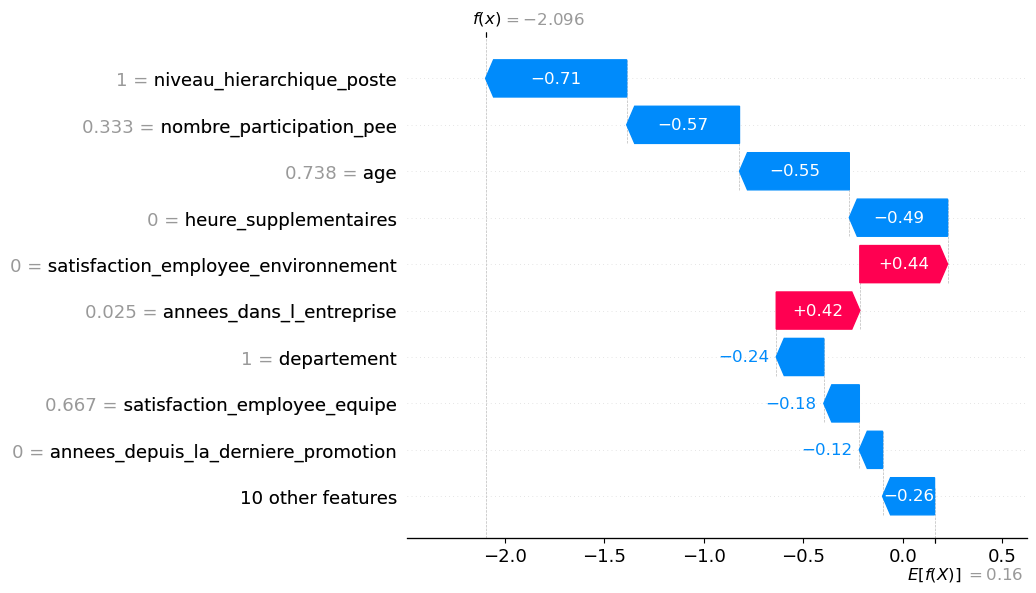

In [48]:
# Indices globaux fixe que nous voulons étudier
label_idx_class0 = 899
label_idx_class1 = 1237

# Positions correspondantes dans X_test / shap_values
pos_class0 = y_test.index.get_loc(label_idx_class0)
pos_class1 = y_test.index.get_loc(label_idx_class1)

# Waterfall Classe 0
shap.plots.waterfall(
    shap.Explanation(
        values=shap_values[pos_class0],
        base_values=explainer.expected_value,
        data=X_test_transformed[pos_class0],
        feature_names=feature_names
    )
)

* Interprétation : Waterfall Plot – Classe 0 (resté dans l’entreprise)

Ce graphique montre comment chaque variable **fait évoluer la prédiction** depuis la valeur moyenne du modèle (*base value*) jusqu’à la sortie finale pour ce profil.

* Prédiction du modèle
- **Score final f(x) = -2.096** -> valeur inférieure au seuil de décision (0).
- Conclusion du modèle : cet individu est **classé en classe 0** → il devrait **rester** dans l’entreprise.

* Facteurs qui poussent vers le départ (classe 1)
- `satisfaction_employee_environnement` (+0.44) : environnement de travail perçu comme moins bon que la moyenne, ce qui tend à accroître le risque de départ.  
- `annees_dans_l_entreprise` (+0.42) : ancienneté plus élevée peut inciter à envisager un changement.  

* Facteurs qui retiennent (classe 0)
- `niveau_hierarchique_poste` (-0.71) : niveau hiérarchique plus bas réduit la probabilité de départ (moins de sollicitations externes, moins de responsabilités).  
- `nombre_participation_pee` (-0.57) : faible ou nulle participation
- `age` (-0.55) : tranche d’âge associée à plus de stabilité professionnelle.
- `heure_supplementaires` (-0.49) : peu ou pas d’heures sup, ce qui diminue le risque de lassitude ou burnout.

* Lecture globale
Malgré quelques variables tirant vers le départ, **le cumul des effets négatifs (vers classe 0)** l’emporte largement.  
Cela signifie que, selon le modèle, les signaux de stabilité (poste, âge, absence de surcharge) dominent les signaux de risque, conduisant à la prédiction « reste ».

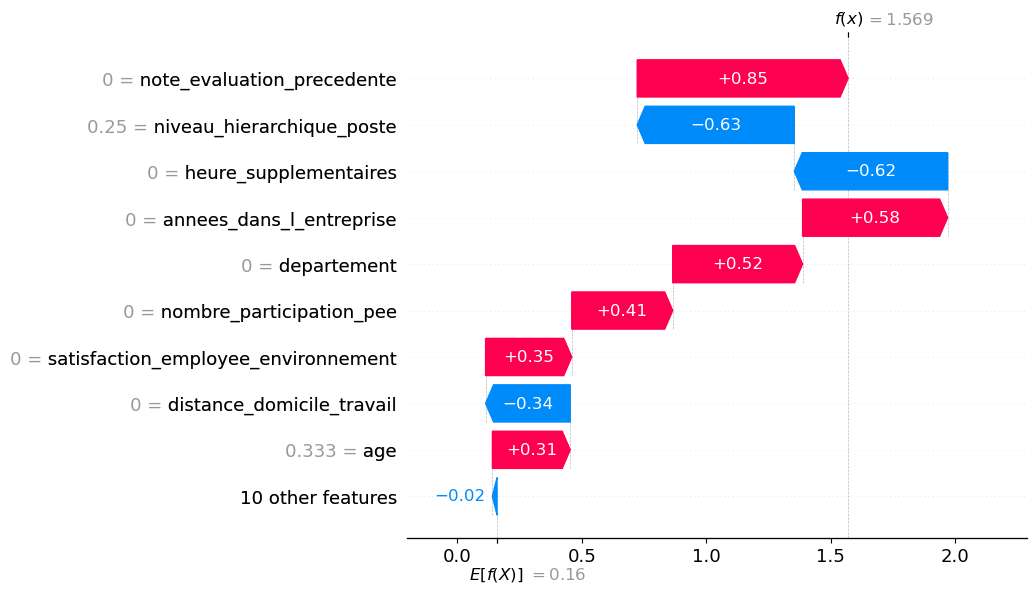

In [170]:
# Waterfall Classe 1
shap.plots.waterfall(
    shap.Explanation(
        values=shap_values[pos_class1],
        base_values=explainer.expected_value,
        data=X_test_transformed[pos_class1],
        feature_names=feature_names
    )
)

* Interprétation : Waterfall Plot – Classe 1 (démissionnaire)

Ce graphique illustre comment chaque variable **influe sur la prédiction** depuis la valeur moyenne du modèle (*base value = 0.16*) jusqu’au score final obtenu pour ce profil.

* Prédiction du modèle
- **Score final f(x) = 1.569** -> supérieur au seuil de décision (0).
- Conclusion : le modèle classe cet individu en **classe 1** -> **probabilité élevée de démission**.

* Facteurs qui poussent vers la démission (classe 1)
- `note_evaluation_precedente` **(+0.85)** : une bonne évaluation peut rendre le profil plus attractif pour d’autres employeurs.
- `annees_dans_l_entreprise` **(+0.58)** : l’ancienneté importante peut inciter à un changement professionnel.
- `departement` **(+0.52)** : certaines équipes ou services peuvent présenter davantage de départs dans les données.
- `nombre_participation_pee` **(+0.41)** : une implication dans certains dispositifs peut corréler avec un profil ambitieux ou ouvert à de nouvelles opportunités.
- `satisfaction_employee_environnement` **(+0.35)** : paradoxalement ici, cette satisfaction peut aller de pair avec la confiance de trouver mieux ailleurs.
- `age` **(+0.31)** : tranche d’âge où la mobilité professionnelle est plus élevée.

* Facteurs qui retiennent (classe 0)
- `niveau_hierarchique_poste` **(-0.63)** : un poste de niveau plus bas réduit le risque de départ.
- `heure_supplementaires` **(-0.62)** : une charge horaire raisonnable peut freiner la lassitude.
- `distance_domicile_travail` **(-0.34)** : une proximité géographique limite la tentation de changement.
- Autres variables mineures : effet global négatif de **-0.02**.

* Lecture globale
Ici, les **facteurs positifs** (en rouge, vers la classe 1) l’emportent nettement sur les facteurs négatifs, poussant la prédiction à **1.569**.  
En résumé, le modèle estime que cet individu est **fortement susceptible de quitter l’entreprise**, en raison d’un cumul de signaux favorables à la mobilité et à l’attractivité professionnelle.

* Utiliser SHAP pour expliquer les effets, Permutation pour prioriser les variables utiles à la performance, et l’importance native comme repère rapide. Leur combinaison sécurise les décisions et enrichit la restitution métier.
* **INTERESSANT AUSSI : Shapash (MAIF) facilite la diffusion des explications auprès des métiers via un dashboard web clair, en connectant modèle, données et valeurs d’explication.**